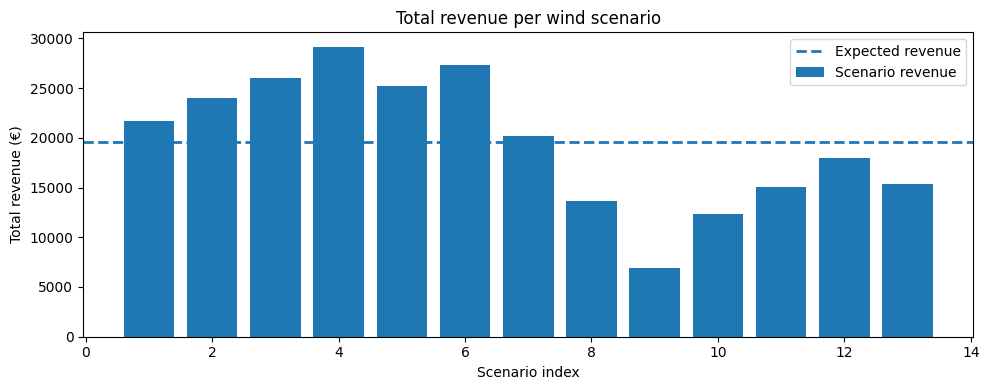

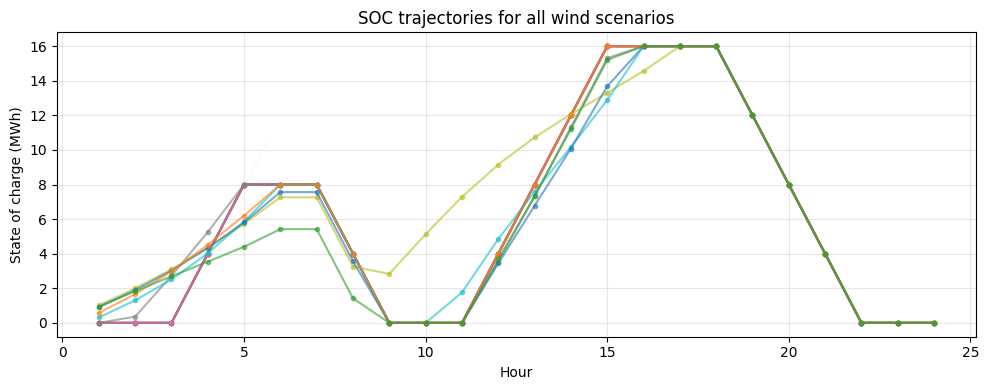

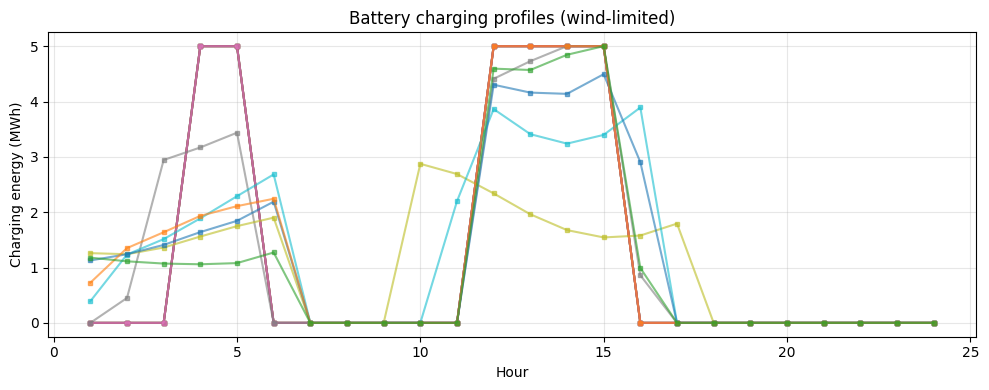

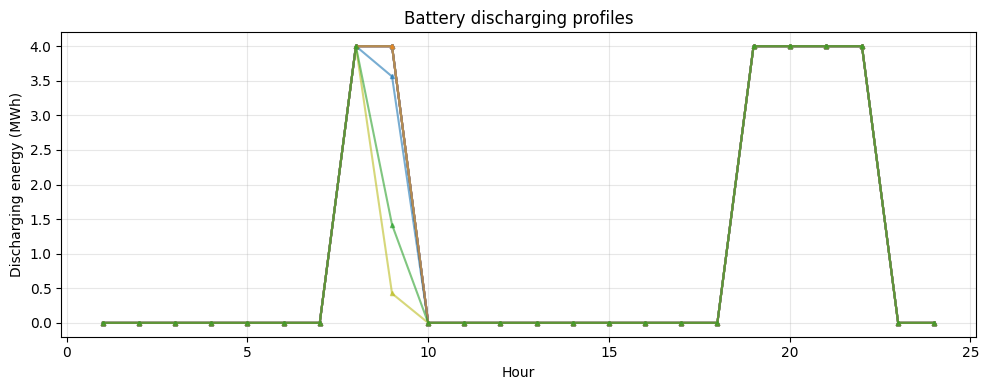

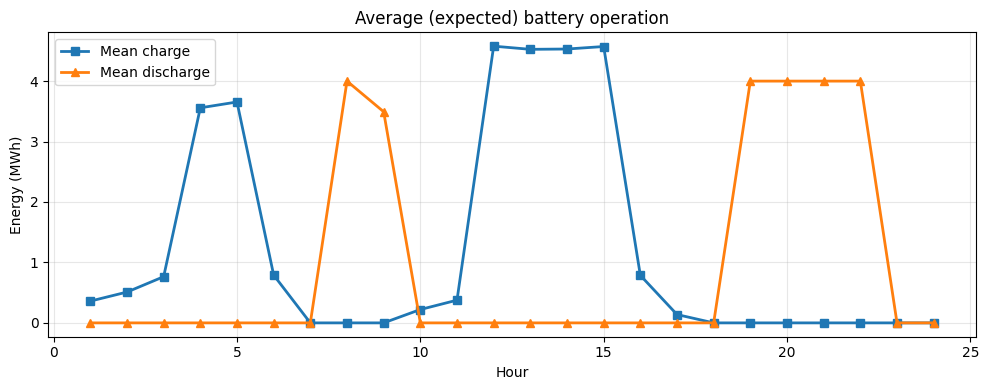

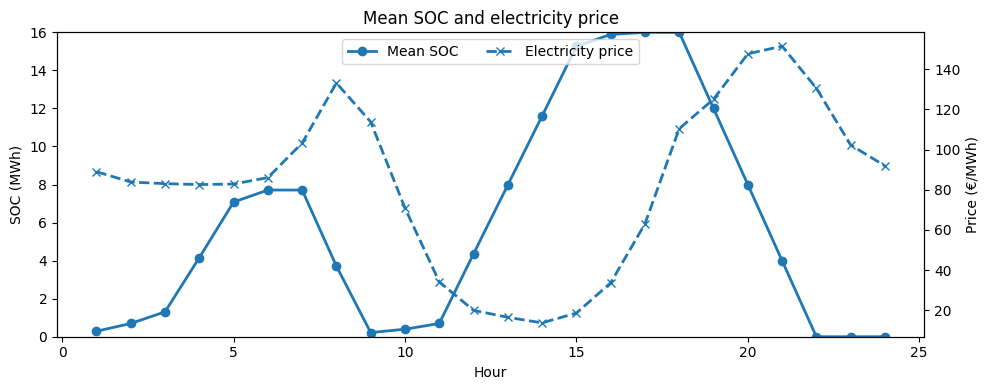

In [1]:
import pandas as pd
import pulp
import numpy as np
import matplotlib.pyplot as plt


# ==========================================================
# Optimization model
# ==========================================================
def solve_stochastic_wind_charge_only(input_csv="input_data.csv"):
    # -----------------------
    # Load data
    # -----------------------
    df = pd.read_csv(input_csv)

    T = list(df["hour"].astype(int))  # 1..24
    price = {t: float(p) for t, p in zip(T, df["price"])}

    scen_cols = [c for c in df.columns if c.startswith("scenario_")]
    S = list(range(len(scen_cols)))
    p_s = 1.0 / len(S)

    wind = {
        t: {s: float(df.loc[df["hour"] == t, scen_cols[s]].values[0]) for s in S}
        for t in T
    }

    # -----------------------
    # Battery parameters
    # -----------------------
    Emax = 16.0
    Pc = 5.0
    Pd = 4.0
    eta_c = 0.8
    max_cycles = 2.0

    # -----------------------
    # Model
    # -----------------------
    m = pulp.LpProblem("Battery_Wind_Stochastic", pulp.LpMaximize)

    # Decision variables (nested dicts)
    c = {t: {s: pulp.LpVariable(f"c_{t}_{s}", lowBound=0) for s in S} for t in T}
    d = {t: {s: pulp.LpVariable(f"d_{t}_{s}", lowBound=0) for s in S} for t in T}
    y = {t: {s: pulp.LpVariable(f"y_{t}_{s}", cat="Binary") for s in S} for t in T}
    soc = {
        t: {s: pulp.LpVariable(f"soc_{t}_{s}", lowBound=0, upBound=Emax) for s in S}
        for t in range(1, 26)
    }

    # -----------------------
    # Constraints
    # -----------------------
    for s in S:
        # Initial / terminal SOC
        m += soc[1][s] == 0
        m += soc[25][s] == 0

        for t in T:
            # Charge only from wind
            m += c[t][s] <= wind[t][s]

            # Power limits and mutual exclusion
            m += c[t][s] <= Pc * y[t][s]
            m += d[t][s] <= Pd * (1 - y[t][s])

            # SOC dynamics
            m += soc[t + 1][s] == soc[t][s] + eta_c * c[t][s] - d[t][s]

        # Cycle limit
        m += pulp.lpSum(d[t][s] for t in T) <= max_cycles * Emax

    # -----------------------
    # Objective: expected revenue
    # -----------------------
    m += pulp.lpSum(
        p_s * pulp.lpSum(price[t] * (wind[t][s] - c[t][s] + d[t][s]) for t in T)
        for s in S
    )

    # -----------------------
    # Solve
    # -----------------------
    m.solve(pulp.PULP_CBC_CMD(msg=False))

    # -----------------------
    # Collect results
    # -----------------------
    schedules = {}
    scenario_revenue = []

    for s in S:
        schedules[s] = pd.DataFrame(
            {
                "hour": T,
                "price": [price[t] for t in T],
                "wind": [wind[t][s] for t in T],
                "charge": [pulp.value(c[t][s]) for t in T],
                "discharge": [pulp.value(d[t][s]) for t in T],
                "soc_end": [pulp.value(soc[t + 1][s]) for t in T],
            }
        )

        rev_s = sum(
            price[t] * (wind[t][s] - pulp.value(c[t][s]) + pulp.value(d[t][s]))
            for t in T
        )
        scenario_revenue.append(rev_s)

    expected_revenue = float(np.mean(scenario_revenue))

    return schedules, scenario_revenue, expected_revenue


# ==========================================================
# Visualization
# ==========================================================
def plot_results(schedules, scenario_revenue, expected_revenue):
    S = list(schedules.keys())
    T = schedules[S[0]]["hour"].values

    # ------------------------------------------------------
    # 1. Total revenue per scenario
    # ------------------------------------------------------
    plt.figure(figsize=(10, 4))
    plt.bar(range(1, len(S) + 1), scenario_revenue, label="Scenario revenue")
    plt.axhline(expected_revenue, linestyle="--", linewidth=2, label="Expected revenue")
    plt.xlabel("Scenario index")
    plt.ylabel("Total revenue (€)")
    plt.title("Total revenue per wind scenario")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ------------------------------------------------------
    # 2. SOC trajectories
    # ------------------------------------------------------
    plt.figure(figsize=(10, 4))
    for s in S:
        plt.plot(
            T,
            schedules[s]["soc_end"],
            marker="o",
            markersize=3,
            linewidth=1.5,
            alpha=0.6,
            label=f"Scenario {s + 1}",
        )
    plt.xlabel("Hour")
    plt.ylabel("State of charge (MWh)")
    plt.title("SOC trajectories for all wind scenarios")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # ------------------------------------------------------
    # 3. Charging profiles
    # ------------------------------------------------------
    plt.figure(figsize=(10, 4))
    for s in S:
        plt.plot(
            T,
            schedules[s]["charge"],
            marker="s",
            markersize=3,
            linewidth=1.5,
            alpha=0.6,
        )
    plt.xlabel("Hour")
    plt.ylabel("Charging energy (MWh)")
    plt.title("Battery charging profiles (wind-limited)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # ------------------------------------------------------
    # 4. Discharging profiles
    # ------------------------------------------------------
    plt.figure(figsize=(10, 4))
    for s in S:
        plt.plot(
            T,
            schedules[s]["discharge"],
            marker="^",
            markersize=3,
            linewidth=1.5,
            alpha=0.6,
        )
    plt.xlabel("Hour")
    plt.ylabel("Discharging energy (MWh)")
    plt.title("Battery discharging profiles")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # ------------------------------------------------------
    # 5. Mean (expected) operation
    # ------------------------------------------------------
    avg = schedules[S[0]][["hour", "price"]].copy()
    avg["charge_mean"] = np.mean([schedules[s]["charge"].values for s in S], axis=0)
    avg["discharge_mean"] = np.mean(
        [schedules[s]["discharge"].values for s in S], axis=0
    )
    avg["soc_mean"] = np.mean([schedules[s]["soc_end"].values for s in S], axis=0)

    plt.figure(figsize=(10, 4))
    plt.plot(T, avg["charge_mean"], marker="s", linewidth=2, label="Mean charge")
    plt.plot(T, avg["discharge_mean"], marker="^", linewidth=2, label="Mean discharge")
    plt.xlabel("Hour")
    plt.ylabel("Energy (MWh)")
    plt.title("Average (expected) battery operation")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # ------------------------------------------------------
    # 6. Mean SOC vs price
    # ------------------------------------------------------
    fig, ax1 = plt.subplots(figsize=(10, 4))

    ax1.plot(T, avg["soc_mean"], marker="o", linewidth=2, label="Mean SOC")
    ax1.set_xlabel("Hour")
    ax1.set_ylabel("SOC (MWh)")
    ax1.set_ylim(0, 16)

    ax2 = ax1.twinx()
    ax2.plot(
        T,
        avg["price"],
        linestyle="--",
        marker="x",
        linewidth=2,
        label="Electricity price",
    )
    ax2.set_ylabel("Price (€/MWh)")

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper center", ncol=2)

    plt.title("Mean SOC and electricity price")
    plt.tight_layout()
    plt.show()


# ==========================================================
# Main
# ==========================================================
if __name__ == "__main__":
    schedules, scenario_revenue, expected_revenue = solve_stochastic_wind_charge_only(
        "input_data.csv"
    )
    plot_results(schedules, scenario_revenue, expected_revenue)
